# **Importing Dependencies and Loading Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

In [2]:
data = pd.read_csv("AMZN.csv")

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [4]:
data = data[['Date','Close']]

In [5]:
# This is the data we want to forecast

data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


We want to train the model on GPU. We perform the following step to see if CUDA is available

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [7]:
device

'cpu'

We now make a simple transformation to transform the 'date' column to pandas datetime

<ipython-input-8-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


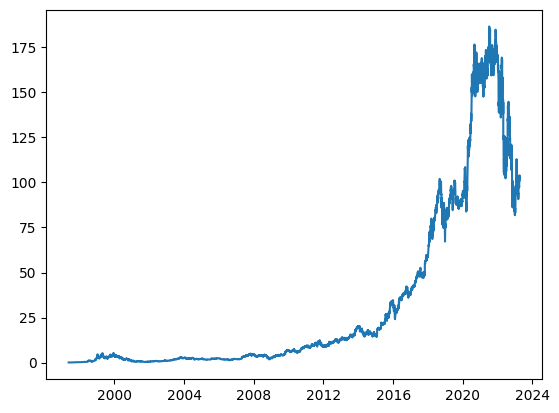

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

# Transforming data to retain history values

In [9]:
from copy import deepcopy as dc                         # Question to answer - what is deepcopy and what does it do?

def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  # df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace=True)
  return df


lookback = 7                                                # for past 7 days from given date
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


**Why do we get history values?**

We are doing the above step as we are looking at the closing stock price each of the past week in history to predict what the closing price today would be.

For example, for date 1997-05-27, we have closing price 0.079167 from the given data.

We get prices from each day of the week prior to 1997-05-27 (i.e. Close(t-1), Close(t-2), ... , Close(t-7) in order to predict the closing price on  1997-05-27.

The same is followed until the last date on the dataset i.e. 2023-04-05.

We choose lookback = 7 because it makes sense to train the model given a week's information

In [10]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the data in range (-1,1)

scaler = MinMaxScaler(feature_range = (-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [12]:
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [13]:
X = shifted_df_as_np[:,1:]           # X has 7 features Close(t-1),...,Close(t-7)
y = shifted_df_as_np[:,0]             # y is target variable - predictor (Close)

X.shape, y.shape

((6509, 7), (6509,))

In [14]:
# We want data in order Close(t-7), Close(t-6), .... , Close(t-1), hence we flip the data

X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

# **Train Test Split**

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=2)

In [21]:
split_index = int(len(X) * 0.95)

split_index

6183

In [23]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [25]:
#  It's a requirement for PyTorch LSTMs to have an extra dimension at the end
# Hence, we reshape the training and testing datasets as follows

X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)
y_train = y_train.reshape(-1,  1)
y_test = y_test.reshape(-1, 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

We see an extra dimension '1' added to the end of the training and testing dataset dimensions.

In [26]:
X_train

array([[[-0.99969839],
        [-0.99982128],
        [-0.99983244],
        ...,
        [-0.99998325],
        [-1.        ],
        [-0.99995531]],

       [[-0.99982128],
        [-0.99983244],
        [-0.99987154],
        ...,
        [-1.        ],
        [-0.99994415],
        [-0.99991063]],

       [[-0.99983244],
        [-0.99987154],
        [-0.99998325],
        ...,
        [-0.99994415],
        [-0.99989946],
        [-0.99993855]],

       ...,

       [[ 0.81682649],
        [ 0.83697653],
        [ 0.88840802],
        ...,
        [ 0.86703009],
        [ 0.84602214],
        [ 0.81766197]],

       [[ 0.83697653],
        [ 0.88840802],
        [ 0.88833832],
        ...,
        [ 0.84602214],
        [ 0.81766298],
        [ 0.81255742]],

       [[ 0.88840802],
        [ 0.88833832],
        [ 0.86703009],
        ...,
        [ 0.81766298],
        [ 0.81255847],
        [ 0.85784967]]])

In [27]:
X_test

array([[[0.88833832],
        [0.86703009],
        [0.84602214],
        ...,
        [0.81255847],
        [0.85785047],
        [0.81019275]],

       [[0.86703009],
        [0.84602214],
        [0.81766298],
        ...,
        [0.85785047],
        [0.81019381],
        [0.82248768]],

       [[0.84602214],
        [0.81766298],
        [0.81255847],
        ...,
        [0.81019381],
        [0.82248867],
        [0.79097548]],

       ...,

       [[0.05779984],
        [0.05158   ],
        [0.0506149 ],
        ...,
        [0.07431453],
        [0.09308121],
        [0.10690997]],

       [[0.05158   ],
        [0.0506149 ],
        [0.04203581],
        ...,
        [0.09308121],
        [0.10691495],
        [0.09747299]],

       [[0.0506149 ],
        [0.04203581],
        [0.07431453],
        ...,
        [0.10691495],
        [0.09747802],
        [0.11398769]]])

In [28]:
y_train

array([[-0.99991063],
       [-0.99993855],
       [-0.99995253],
       ...,
       [ 0.81255742],
       [ 0.85784967],
       [ 0.81019275]])

We have worked with NumPy so far but since we're running this using PyTorch, we do the train test split in PyTorch tensors

In [29]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [30]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [31]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [32]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


# **LSTM Neural Network**

Long short-term memory (LSTM) is a type of recurrent neural network (RNN) that can store and apply information over time. LSTMs are used to learn, process, and classify sequential data, such as language, speech, audio, and video.

LSTMs are designed to prevent the neural network output from decaying or exploding as it cycles through feedback loops. They do this by using specialized "gates" to manage short-term and long-term memory. These gates include the "forget gate," "input gate," and "output gate".

LSTMs are able to learn long-term dependencies between time steps of data, which makes them better than other RNN architectures at solving sequence learning tasks.

**LSTM (Long Short-Term Memory):**
LSTM is a type of neural network designed for processing sequential data (e.g., time series, sentences). It "remembers" information over time, making it useful for tasks like forecasting or language modeling.

**Hidden State and Cell State:**
These are internal states of the LSTM that carry information through time steps, allowing it to capture dependencies in the data.

**Fully Connected (Linear) Layer:**
This layer transforms the LSTM output into the desired shape for predictions. In this case, it reduces the hidden state dimension to a single output value.

**Sequence Processing:**
The input to the LSTM is a sequence of data points (e.g., daily temperatures), and the model processes this sequence to predict a target value (e.g., tomorrow's temperature).

In [33]:
# Define a custom Long Short-Term Memory (LSTM) model
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_stacked_layers):

        # Initialize the parent class (nn.Module) and set up the model's components

        super().__init__()
        self.hidden_size = hidden_size  # Number of hidden units in the LSTM layer
        self.num_stacked_layers = num_stacked_layers  # Number of LSTM layers to stack

        # Define the LSTM layer
        # LSTM is a type of recurrent neural network (RNN) used for sequence data

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)  # batch_first=True means input shape is (batch_size, sequence_length, input_size)

        # Define a fully connected (linear) layer to map the LSTM's output to a single value
        self.fc = nn.Linear(hidden_size, 1)  # Produces one output value per sample

    def forward(self, x):
        # Define the forward pass: how the model processes input to produce output
        # x: input tensor with shape (batch_size, sequence_length, input_size)

        batch_size = x.size(0)  # Get the batch size (number of samples in the batch)

        # Initialize the hidden state (h0) and cell state (c0) for the LSTM
        # These are required for the LSTM to "remember" information across the sequence

        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Pass the input through the LSTM layer
        # The LSTM produces an output for each time step and updates its hidden states

        out, _ = self.lstm(x, (h0, c0))  # _ is used to ignore the second output (hidden states)

        # Take the output from the last time step of the sequence (out[:, -1, :])
        # Pass it through the fully connected layer to produce the final output

        out = self.fc(out[:, -1, :])  # Only the output of the last time step is used
        return out  # Return the final output (predicted value)

# Create an instance of the LSTM model
# input_size = 1 (number of features in the input), hidden_size = 4 (hidden units in the LSTM), num_stacked_layers = 1 (one LSTM layer)
model = LSTM(1, 4, 1)

# Move the model to the specified device (e.g., GPU or CPU)
model.to(device)

# Print the model architecture to visualize its layers and structure
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

**Epoch:**
One epoch means the model has seen the entire dataset once. Since the data is processed in smaller chunks (batches), multiple batches make up one epoch.

**Batch:**
A batch is a small subset of the training data. Breaking the data into batches allows the model to train more efficiently and fit into memory.

**Loss Function:**
A loss function measures how far the model's predictions are from the actual labels. The goal of training is to minimize this loss.

**Optimizer:**
The optimizer updates the model's weights to reduce the loss based on the gradients computed during backpropagation.

**Backpropagation:**
A process where the model learns by adjusting its weights in the direction that reduces the loss.

**Monitoring Progress:**
Printing the average loss every 100 batches provides insights into how well the model is learning and whether the loss is decreasing as expected.

In [34]:
def train_one_epoch():
    """
    This function trains the model for one full cycle (epoch) through the entire training dataset.
    """

    # Set the model to training mode
    # This tells the model to behave differently during training (e.g., applying dropout, updating weights).
    model.train(True)

    # Print the current epoch number (for tracking progress)
    print(f'Epoch: {epoch + 1}')

    # Initialize a variable to track the total loss for the current epoch
    running_loss = 0.0

    # Loop through batches of data from the training dataset
    # train_loader is an object that provides data in small chunks (batches)

    for batch_index, batch in enumerate(train_loader):

        # Extract the input data (x_batch) and corresponding labels (y_batch) from the batch
        # Move the data to the appropriate device (e.g., GPU or CPU)

        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Pass the input data through the model to get predictions

        output = model(x_batch)

        # Calculate the difference (loss) between the model's predictions and the actual labels
        # The loss function measures how well the model is performing

        loss = loss_function(output, y_batch)

        # Add the current batch's loss to the running total for this epoch

        running_loss += loss.item()

        # Reset the gradients of the optimizer
        # This ensures that the gradients from previous batches don't accumulate

        optimizer.zero_grad()

        # Perform backpropagation to compute gradients (how much each weight should change)

        loss.backward()

        # Update the model's weights based on the gradients

        optimizer.step()

        # Print the average loss for every 100 batches to monitor training progress

        if batch_index % 100 == 99:  # Check if the batch index is divisible by 100
            avg_loss_across_batches = running_loss / 100  # Calculate the average loss for the last 100 batches
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0  # Reset the running loss for the next set of 100 batches

    # Print an empty line for better readability between epochs
    print()


**Validation:**
Validation checks how well the model performs on data it has never seen before (test data). This helps ensure the model isn't just memorizing the training data but learning patterns that generalize to new data.

**Evaluation Mode:**
Setting the model to evaluation mode (model.train(False)) ensures that features like dropout (used during training to prevent overfitting) are turned off for consistent predictions.

**No Gradients (torch.no_grad()):**
During validation, we don't compute gradients or update the model's weights, so disabling these calculations saves computational resources.

**Loss Function:**
The loss function measures the difference between the model's predictions and the actual labels. Lower loss values indicate better performance.

**Average Loss:**
The average loss across all batches gives a single metric to summarize the model's performance on the test dataset.

In [35]:
def validate_one_epoch():
    """
    This function evaluates (validates) the model's performance on unseen test data
    for one complete cycle (epoch). It helps assess how well the model generalizes to new data.
    """

    # Set the model to evaluation mode
    # This disables training-specific behavior like dropout, ensuring stable predictions.
    model.train(False)

    # Initialize a variable to track the total loss during validation
    running_loss = 0.0

    # Loop through batches of data from the test dataset
    # test_loader provides small chunks (batches) of test data
    for batch_index, batch in enumerate(test_loader):
        # Extract the input data (x_batch) and corresponding labels (y_batch) from the batch
        # Move the data to the appropriate device (e.g., GPU or CPU)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disable gradient calculations
        # This saves memory and speeds up evaluation since we don't need to update weights during validation
        with torch.no_grad():
            # Pass the input data through the model to get predictions
            output = model(x_batch)

            # Calculate the loss between the predictions and actual labels
            # This measures how well the model is performing on the test data
            loss = loss_function(output, y_batch)

            # Add the current batch's loss to the running total for validation
            running_loss += loss.item()

    # Calculate the average loss across all batches in the test dataset
    avg_loss_across_batches = running_loss / len(test_loader)

    # Print the average validation loss for this epoch
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))

    # Print a separator for better readability between epochs
    print('***************************************************')
    print()


In [36]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.483
Batch 200, Loss: 0.082
Batch 300, Loss: 0.017

Val Loss: 0.021
***************************************************

Epoch: 2
Batch 100, Loss: 0.006
Batch 200, Loss: 0.006
Batch 300, Loss: 0.004

Val Loss: 0.016
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.003

Val Loss: 0.011
***************************************************

Epoch: 4
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.009
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.006
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
*****************

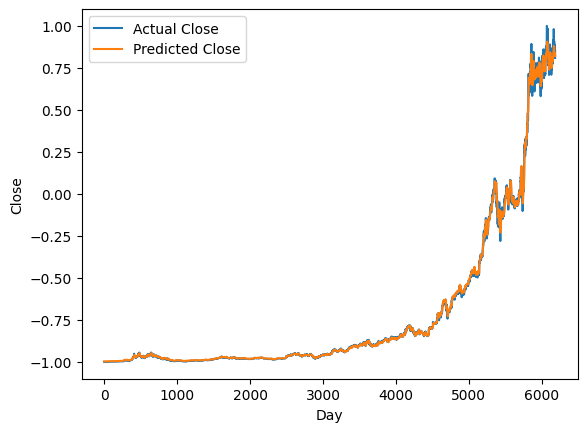

In [37]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [38]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = train_predictions                 # first column is set to predictions that we have
dummies = scaler.inverse_transform(dummies)       # rest of the matrix is set to inverse transform (we had scaled the matrix values between -1 and 1 earlier, we are denormalizing the values to the original values in this step)

train_predictions = dc(dummies[:,0])
train_predictions

array([  0.36172849,   0.36188967,   0.36145614, ..., 170.40401693,
       169.79925979, 170.12717793])

In [39]:
# We do the above step for y_train as well

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

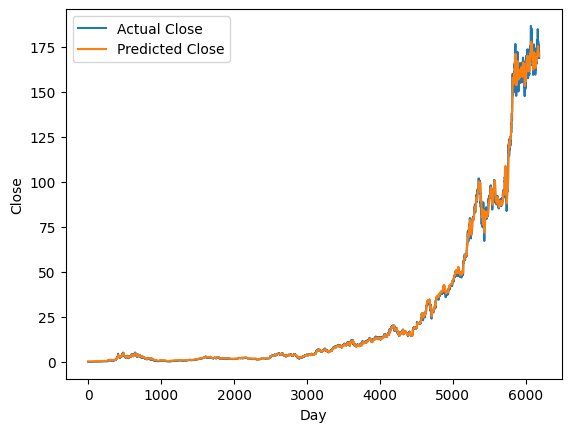

In [40]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [41]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([169.4327238 , 169.12014607, 168.34514362, 168.46348718,
       168.75944056, 169.01365799, 168.81877352, 168.96626388,
       168.75771198, 168.5604931 , 167.93737748, 168.18876583,
       167.81930627, 166.91914045, 165.95672921, 165.11093294,
       164.25942849, 164.51457413, 164.59775144, 163.8800977 ,
       163.59956811, 162.70429344, 161.4397982 , 159.42029865,
       155.5093976 , 152.93106767, 149.91042787, 147.2520443 ,
       145.52573573, 145.46460749, 147.07519038, 149.10445   ,
       150.40874139, 148.49272853, 151.86134574, 154.48434631,
       157.14355804, 158.87100046, 159.57332489, 158.73830027,
       158.93037789, 158.77098759, 159.04156814, 158.34359016,
       157.30638881, 155.97454024, 153.79638962, 153.70123455,
       154.22556565, 154.5363092 , 154.28821126, 154.36864842,
       153.46678736, 152.39441977, 149.17295387, 146.17611395,
       144.77195975, 145.84685073, 146.31432779, 145.84814578,
       147.00267355, 149.70764531, 152.86512054, 156.07

In [42]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

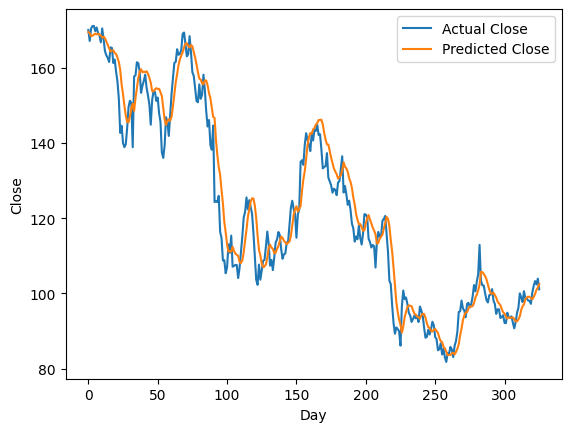

In [43]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()